In [16]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install numpy==1.15.4 --user
!{sys.executable} -m pip install keras==2.1.3 --user
!{sys.executable} -m pip install pandas==0.23.4 --user
!{sys.executable} -m pip install scikit-image==0.14.1 --user
!{sys.executable} -m pip install scikit-learn==0.19.0 --user
!{sys.executable} -m pip install tensorflow --user
!{sys.executable} -m pip install imgaug --user



  Using cached https://files.pythonhosted.org/packages/c2/d7/90f34cb0d83a6c5631cf71dfe64cc1054598c843a92b400e55675cc2ac37/pip-18.1-py2.py3-none-any.whl
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1
  Rolling back uninstall of pip
Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/lib/python3.6'
Consider using the `--user` option or check the permissions.

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import keras
import skimage
import tensorflow
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import skimage.morphology as morp
from skimage.filters import rank

%matplotlib inline

assert pd.__version__ == '0.23.4'
assert np.__version__ == '1.15.4'
assert keras.__version__ == '2.1.3'
assert skimage.__version__ == '0.14.1'
assert sklearn.__version__ == '0.19.2'
assert tensorflow.__version__ == '1.12.0'


Using TensorFlow backend.


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [18]:
train = pd.read_csv("../data/train.csv")
train_labels = train["Label"].values
train = train.sort_values("Img_Name").reset_index(drop=True)
train.head()

,Img_Name,Top,Left,Width,Height,Label
0,01-05 10.15.27_2.jpg,248,422,17,24,Speed Limit 60
1,01-05 10.15.38.jpg,360,765,45,60,Speed Limit 40
2,01-07 11.34.55.jpg,111,958,95,148,Speed Limit 20
3,01-07 16.39.19.jpg,282,1113,55,78,Speed Limit 40
4,01-09 01.46.39.jpg,357,872,30,31,Speed Limit 50


In [19]:
# Load all images. 

import os
import skimage.data
def load_data(data_dir):
    images = []
    
    file_names = sorted([os.path.join(data_dir, f)
                         for f in os.listdir(data_dir) if f.endswith(".jpg")])
    
    for f in file_names:
        images.append(skimage.data.imread(f)) #as_gray=True))

    return images

%time images = load_data('../data/object-detection-train')
print(len(images))

CPU times: user 17.3 s, sys: 1.17 s, total: 18.4 s
Wall time: 18.7 s
467


In [ ]:
# for a in images:
#     if a.shape != (720, 1280, 3):
#         print(a.shape)

In [ ]:
# #transform all images to 360x640
# import skimage.transform

# image_size = (180,320)
# %time images_transformed = np.array([skimage.transform.resize(image, image_size) for image in images])

In [20]:
bb_orig = train[["Top", "Left", "Width", "Height"]].values
# bb = np.array([[x] for x in bb])
bb_orig.shape



(467, 4)

In [21]:
import imgaug as ia
from imgaug import augmenters as iaa

ia.seed(1)

# call with bb_orig and images
image_size = (90,160)
def get_rescaled_img_and_bb(images, bb_orig, image_size=image_size):

    # Define image with two bounding boxes
    # image = ia.quokka(size=(256, 256))
    bbs = [ia.BoundingBoxesOnImage([
                ia.BoundingBox(
                    x1=bb_orig[i][0], 
                    x2=bb_orig[i][0] + bb_orig[i][3], 
                    y1=bb_orig[i][1], 
                    y2=bb_orig[i][1] + bb_orig[i][2]
                ),
            ], shape=images[i].shape)
           for i in range(len(images))]
    
    # Rescale image and bounding boxes
    images_rescaled = [ia.imresize_single_image(img, image_size) for img in images]
       
    bbs_rescaled = [bbs[i].on(images_rescaled[i]) for i in range(len(bbs))]
    
    # # Draw image before/after rescaling and with rescaled bounding boxes
    # image_bbs = [bbs[i].draw_on_image(images_rescaled[i], thickness=2) for i in range(len(bbs))]
    # image_rescaled_bbs = [bbs_rescaled[i].draw_on_image(images_rescaled[i], thickness=2) for i in range(len(bbs))]
    
    bbs_rescaled_fixed = []
    for i in range(len(bbs_rescaled)):
        t = int(bbs_rescaled[i].bounding_boxes[0].x1)
        l = int(bbs_rescaled[i].bounding_boxes[0].y1)
        w = int(bbs_rescaled[i].bounding_boxes[0].y2 - bbs_rescaled[i].bounding_boxes[0].y1)
        h = int(bbs_rescaled[i].bounding_boxes[0].x2 - bbs_rescaled[i].bounding_boxes[0].x1)
        bbs_rescaled_fixed.append((t,l,w,h))

    return (images_rescaled, bbs_rescaled_fixed)

%time images_rescaled, bbs_rescaled = get_rescaled_img_and_bb(images, bb_orig)

CPU times: user 155 ms, sys: 4.31 ms, total: 159 ms
Wall time: 157 ms


In [43]:
# # for image in image_rescaled_bbs[:3]:
# image = (image_rescaled_bbs[10]).astype(np.uint8)
# im = Image.fromarray(image)
# plt.figure()
# plt.imshow(im)
# plt.show()

In [22]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

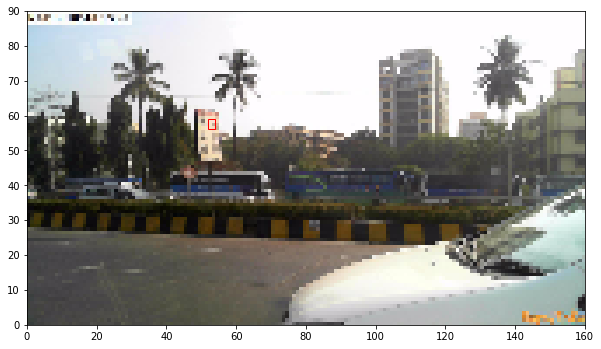

In [195]:
def draw_img_bb(image, bb, bb_pred=None, image_size=None):
    if image_size:
        bb = bb*image_size
        if bb_pred:
            bb_pred = bb_pred*image_size
    plt.figure(figsize=(10, 10))
    plt.imshow((image).astype(np.uint8), cmap='Greys', interpolation='none', origin='upper', extent=[0, image.shape[1], 0, image.shape[0]])
    if bb_pred:
        plt.gca().add_patch(matplotlib.patches.Rectangle((bb_pred[1], image.shape[0]-bb_pred[0]-bb_pred[3]), bb_pred[2],bb_pred[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(bb_pred, bb)), (bb_pred[1], image.shape[0]-bb_pred[0]-bb_pred[3]+bb_pred[3]+10), color='r')
    plt.gca().add_patch(matplotlib.patches.Rectangle((bb[1], image.shape[0]-bb[0]-bb[3]), bb[2],bb[3], ec='r', fc='none'))
    plt.show()
    
    
draw_img_bb(images_rescaled[0], y[0], image_size=max(image_size))
# draw_img_bb(images_rescaled[3], bbs_rescaled[3])#, [200, 400, 20,20])

In [ ]:
# weird_imgs = [images_transformed[i] for i in range(len(images_transformed))
#               if images[i].shape != (720,1280,3)]

# print(len(weird_imgs))

# from PIL import Image

# for image in weird_imgs[:3]:
#     image = (image * 255).astype(np.uint8)
#     im = Image.fromarray(image)
#     plt.figure()
#     plt.imshow(im)
#     plt.show()



In [ ]:
# for image in images_transformed[:3]:
#     image = (image * 255).astype(np.uint8)
#     im = Image.fromarray(image)
#     plt.figure()
#     plt.imshow(im)
#     plt.show()



In [ ]:
# # Create images with random rectangles and bounding boxes. 
# num_imgs = 50000

# img_size = 8
# min_object_size = 1
# max_object_size = 4
# num_objects = 1

# bboxes = np.zeros((num_imgs, num_objects, 4))
# imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0

# for i_img in range(num_imgs):
#     for i_object in range(num_objects):
#         w, h = np.random.randint(min_object_size, max_object_size, size=2)
#         x = np.random.randint(0, img_size - w)
#         y = np.random.randint(0, img_size - h)
#         imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
#         bboxes[i_img, i_object] = [x, y, w, h]
        
# imgs.shape, bboxes.shape

In [23]:
def norm_X(X):
#     X_norm = (X - np.mean(images_rescaled)) / np.std(images_rescaled)
    X_norm = X / 255.
    return X_norm

def denorm_X(X_norm):
#     X_denorm = X_norm * np.std(images_rescaled) + np.mean(images_rescaled)
    X_denorm = X_norm * 255.
    return X_denorm

def norm_y(y, image_size):
    y_norm = y / max(image_size)
    return y_norm

def denorm_y(y_norm, image_size):
    y_denorm = y_norm * max(image_size)
    return y_denorm

X = np.array(images_rescaled)

# Reshape and normalize the image data to mean 0 and std 1. 
X = norm_X(X)

X.shape, np.mean(X), np.std(X)


((467, 90, 160, 3), 0.5349708179964805, 0.26961403240491283)

In [24]:
y = np.array(bbs_rescaled)
y = norm_y(y, image_size)
y.shape, np.mean(y), np.std(y)

((467, 4), 0.16941581905781586, 0.20106967488797006)

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:

total_epochs_trained = 0
model = Sequential()
model.add(Conv2D(32, (4, 4), input_shape=(image_size[0],image_size[1],3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

from keras.optimizers import SGD
opt = SGD(lr=0.05)

model.compile(loss='mse',
              optimizer='rmsprop')
#               metrics=['mse']) 

# NOTE: If loss=categorical_crossentropy, 
# then 'accuracy' metrics == categorical_accruacy

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 87, 157, 32)       1568      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 78, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 43, 78, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 76, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 38, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 38, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 24320)             0         
__________

In [ ]:
epochs_per_round = 1
epoch_acc = []
print("IOU+MSE AFTER", total_epochs_trained, "EPOCHS:\n")

for i in range(10):
    # fits the model on batches with real-time data augmentation:

    model.fit(X_train, y_train, epochs=epochs_per_round, batch_size=32, verbose=1)

    total_epochs_trained += epochs_per_round

    pred = model.predict(X_test)

    IOUs = [IOU(pred[i],y_test[i]) for i in range(len(pred))]
    
    mean_IOU = np.mean(IOUs)

    print("EPOCH #", total_epochs_trained, "(mean IOU):", mean_IOU)
    if list(pred[0]) == list(pred[1]):
        print("Preds are the same...")
    
    epoch_acc.append((mean_IOU, total_epochs_trained))
    
    


IOU+MSE AFTER 0 EPOCHS:

Epoch 1/1
373/373 [==============================] - 5s 14ms/step - loss: 0.0576
EPOCH # 1 (mean IOU): 0.00047345660165132
Epoch 1/1
373/373 [==============================] - 4s 12ms/step - loss: 0.0311
EPOCH # 2 (mean IOU): 0.0004342907321286101
Epoch 1/1
373/373 [==============================] - 5s 12ms/step - loss: 0.0327
EPOCH # 3 (mean IOU): 0.0007824124209038204
Epoch 1/1
373/373 [==============================] - 5s 12ms/step - loss: 0.0311
EPOCH # 4 (mean IOU): 0.0003595192271416847
Epoch 1/1
373/373 [==============================] - 5s 13ms/step - loss: 0.0305
EPOCH # 5 (mean IOU): 0.0002497250371767429
Epoch 1/1
128/373 [=========>....................] - ETA: 3s - loss: 0.0296

In [192]:
pred_denorm = denorm_y(pred,image_size)
pred_denorm[:10]

array([[47.04655 , 57.577   , 23.090652, 32.285793],
       [46.593903, 53.16543 , 26.655272, 33.585384],
       [46.660484, 58.373333, 23.246553, 31.719625],
       [46.56074 , 61.339527, 21.471643, 30.628075],
       [41.114487, 89.38954 ,  9.68486 , 19.811111],
       [46.924667, 61.953423, 20.451763, 30.670135],
       [46.741127, 57.942883, 23.38507 , 31.930927],
       [45.880352, 56.23707 , 25.991535, 31.891048],
       [47.19931 , 56.961044, 23.21718 , 32.62246 ],
       [46.90177 , 57.94533 , 23.105402, 32.047504]], dtype=float32)

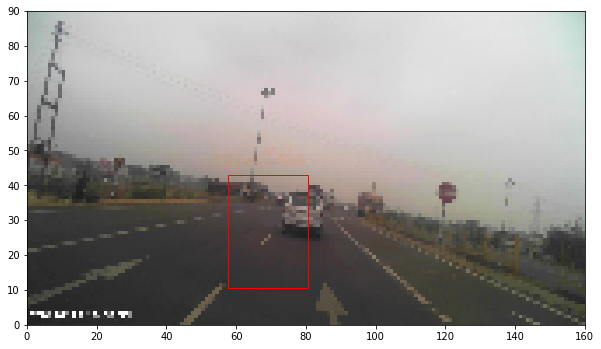

In [196]:
i = 0
draw_img_bb(denorm_X(X_test[i]), denorm_y(pred[i], image_size))
# draw_img_bb(X_test[i], y_test[i], pred[i])


In [197]:
pred

array([[0.29404095, 0.35985625, 0.14431658, 0.2017862 ],
       [0.2912119 , 0.3322839 , 0.16659544, 0.20990865],
       [0.29162803, 0.36483333, 0.14529096, 0.19824766],
       [0.29100463, 0.38337204, 0.13419777, 0.19142547],
       [0.25696555, 0.55868465, 0.06053038, 0.12381945],
       [0.29327917, 0.38720888, 0.12782352, 0.19168834],
       [0.29213205, 0.362143  , 0.1461567 , 0.1995683 ],
       [0.2867522 , 0.35148168, 0.1624471 , 0.19931905],
       [0.2949957 , 0.35600653, 0.14510737, 0.20389038],
       [0.29313606, 0.36215833, 0.14440876, 0.20029691],
       [0.29686552, 0.36030957, 0.13915068, 0.20367427],
       [0.28241348, 0.4234102 , 0.1211033 , 0.17307298],
       [0.2958496 , 0.38302863, 0.12625998, 0.1948618 ],
       [0.28599012, 0.33885217, 0.17187208, 0.20328556],
       [0.28463012, 0.39155388, 0.13948974, 0.18432626],
       [0.29290944, 0.36275864, 0.14441475, 0.19991714],
       [0.29782215, 0.36473295, 0.13470553, 0.20273936],
       [0.29490536, 0.37779886,